In [1]:
# Dependencies
import tweepy
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
from requests_oauthlib import OAuth1
import matplotlib.ticker as ticker
%matplotlib notebook

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

# News Mood

In [2]:
#create function to get N tweet from a user and do sentiments analysis, 
#save result to a dataframe and return that data frame
#user_name is the twitter account, and n is how many tweets need to be analyzed
def sent_analysis (user_name, n):     
    tweet_count = 0
    result_list=[]
    oldest_tweet = None
    #pages need to be called, since each time line page have 20 tweets
    page_required = int(n/20 +1)     
    for x in range(page_required):
        public_tweet = api.user_timeline(user_name, max_id=oldest_tweet)        
        for tweet in public_tweet:
            
            #if condition to check if we get enough tweets already
            if tweet_count<n:       
                name=(tweet["user"]["name"])
                date=(tweet["created_at"])
                text=(tweet["text"])
                oldest_tweet=tweet["id"]
                results = analyzer.polarity_scores(tweet["text"])
                compound=(results["compound"])
                positive=(results["pos"])
                negative=(results["neg"])
                neutral=(results["neu"])               
                
                #create a sentiment dictionary
                sentiment={"User":name,
                            "Date":date[:19],
                            "Text":text,
                            "Compound":compound,
                            "Positive":positive,
                            "Negative": negative,
                            "Neutral":neutral,
                            "Tweets Ago":tweet_count}
                tweet_count+=1              
                #append the sentiment dictionary to a list
                result_list.append(sentiment)

    #make it a dataframe and change the order of the column
    result_df = pd.DataFrame(result_list).round(3)
    result_df = result_df[["User","Text","Date","Positive","Neutral","Negative","Compound","Tweets Ago"]]
    
    #return the dataframe
    return result_df
 

In [3]:
#start to run function on each news sources
bbc_df = sent_analysis(user_name="BBC",n=100)
cbs_df = sent_analysis(user_name="CBS",n=100)
cnn_df = sent_analysis(user_name="CNN",n=100)
fox_df = sent_analysis(user_name="FoxNews",n=100)
nyt_df = sent_analysis(user_name="nytimes",n=100)


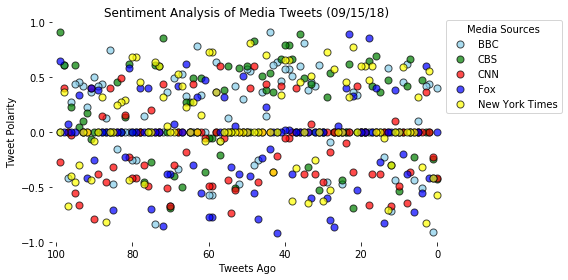

In [4]:
#set proper figure size and plot for each dataframe
plt.figure(figsize=(8,4))
bbc_plot=plt.scatter(bbc_df["Tweets Ago"],bbc_df["Compound"],label="BBC",facecolor="skyblue",edgecolor = "black",s=50,alpha=0.7)
cbs_plot=plt.scatter(cbs_df["Tweets Ago"],cbs_df["Compound"],label="CBS",facecolor="green",edgecolor = "black",s=50,alpha=0.7)
cnn_plot=plt.scatter(cnn_df["Tweets Ago"],cnn_df["Compound"],label="CNN",facecolor="r",edgecolor = "black",s=50,alpha=0.7)
fox_plot=plt.scatter(fox_df["Tweets Ago"],fox_df["Compound"],label="Fox",facecolor="blue",edgecolor = "black",s=50,alpha=0.7)
nyt_plot=plt.scatter(nyt_df["Tweets Ago"],nyt_df["Compound"],label="New York Times",facecolor="yellow",edgecolor = "black",s=50,alpha=0.7)

#set label, legend
plt.xlim(101,-1)
plt.legend(title="Media Sources",loc='center left',bbox_to_anchor=(1,0.8))
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.ylim(-1,1)
plt.box(on=None)

#set y ticker locator
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))

#set title to reflect the time of the analysis
now=datetime.now()
now_date = now.strftime("%m/%d/%y")
plt.title(f"Sentiment Analysis of Media Tweets ({now_date})")
plt.tight_layout()

#save the picture
plt.savefig("Result/Sentiment_Analysis_of_Media_Tweets")
plt.show()

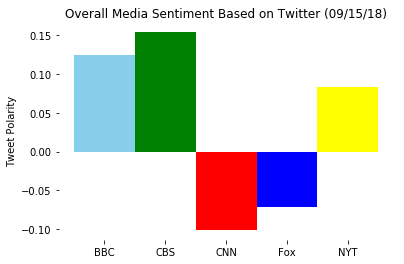

In [5]:
#create list for the bar chart
name_list = ["BBC","CBS","CNN","Fox","NYT"]
ave_compound=[bbc_df["Compound"].mean(),
              cbs_df["Compound"].mean(),
              cnn_df["Compound"].mean(),
              fox_df["Compound"].mean(),
              nyt_df["Compound"].mean()]
#set color for each bar
color = ["skyblue","green","red","blue","yellow"]

#plot the bar chart
media_bar = plt.bar(name_list,ave_compound,color=color,align="center",width=1.0)
plt.box(on=None)
plt.ylabel("Tweet Polarity")
plt.title(f"Overall Media Sentiment Based on Twitter ({now_date})")
plt.savefig("Result/Overall_Media_Sentiment_Based_on_Twitter")
plt.show()

# PlotBot

In [2]:
#setup url and auth for mention timeline
base_url = "https://api.twitter.com/1.1/statuses/mentions_timeline.json?key=auth"
auth1 = OAuth1(consumer_key, consumer_secret,access_token, access_token_secret)

In [15]:
#set a function to do api call and analysis
def plotbot_analysis (news_name):
    oldest_tweet = None
    tweet_count=0
    
    #create 2 empty list 
    compound_list=[]
    tweet_ago=[]    
    
    for x in range(25):     #20 tweets each, so 25 pages are needed
        #api request and save required info into the list
        public_tweet = api.user_timeline(news_name, max_id=oldest_tweet)
        for tweet in public_tweet:
            oldest_tweet=tweet["id"]
            results = analyzer.polarity_scores(tweet["text"])
            compound_list.append(results["compound"])
            tweet_ago.append(tweet_count)
            tweet_count = tweet_count+1
            
    #create the dataframe with 2 list and return it
    result_df = pd.DataFrame({"Tweets Ago":tweet_ago,
                              "Compound":compound_list })
    return result_df
                   

In [14]:
#set up function to do the plot
#tweet_compound is a dataframe with column["Tweets Ago","Compound"]
#analysis_name is the name of tweet account that is required to be analyzed
#request_id is the id of the tweet that made the request.
def tweet_plot(tweet_compound, analysis_name, request_id ):
    #set proper figure size and plot
    plt.figure(figsize=(8,4))
    analysis_plot = plt.plot(tweet_compound["Tweets Ago"],tweet_compound["Compound"],\
                        linewidth=0.5,color="deepskyblue",marker="o",label=f"@{analysis_name}")
    
    #setup legend, label and title
    plt.xlim(501,-1)
    plt.legend(title="Tweets",loc='center left',frameon=False, bbox_to_anchor=(1,0.8))
    plt.ylabel("Tweet Polarity")
    plt.xlabel("Tweets Ago")
    plt.ylim(-1,1)
    plt.box(on=None)
    now=datetime.now()
    now_time = now.strftime("%m/%d/%y %I:%M %p")
    plt.title(f"Sentiment Analysis of Media Tweets ({now_time})")
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    plt.tight_layout()                    
    
    #save the plot with unique name and return the path of the file
    plt.savefig(f"Result/request_{request_id}.png")
    plt.show()
    return (f"Result/request_{request_id}.png")
    

There is some error, or there is no request. Skip
   Tweets Ago  Compound
0           0    0.6739
1           1    0.7263
2           2    0.5267
3           3    0.0000
4           4    0.0000


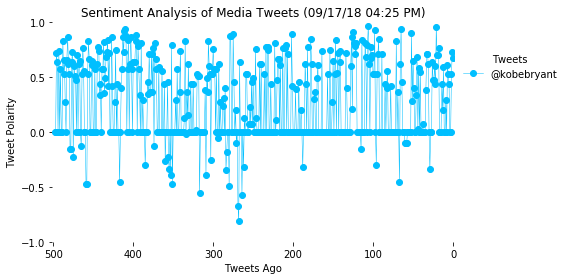

This user already made a request recently.
   Tweets Ago  Compound
0           0    0.0000
1           1    0.4926
2           2    0.3818
3           3    0.7345
4           4    0.7424


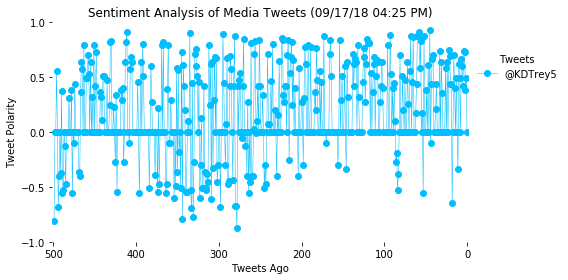

This user already made a request recently.
   Tweets Ago  Compound
0           0    0.6249
1           1    0.8074
2           2    0.0000
3           3    0.6114
4           4    0.8087


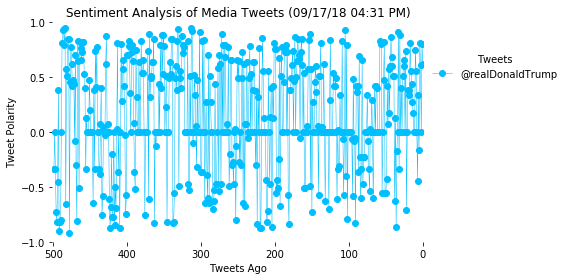

KeyboardInterrupt: 

In [18]:
#get the id of most recent tweet on mention time line. So when the robot start to run,
#it will start to looking for any mention after that one
respond= requests.get(base_url,auth=auth1).json()
newest_mention = respond[0]["id"]

while (True):
    request_count=0     #save the # of analysis in 5-minutes block, 
                        #I set my robot to an maximum of 5 analysis in one 5-minutes block
    
    
    requested_user=[]  #list to save users that have made one request in one 5-minutes block
                       #I set my robot to repond only once to a same user in one 5-minutes block
    
    #api request to get my mention timeline
    mention_tweets= requests.get(f"{base_url}&since_id={newest_mention}",auth=auth1).json()
    try:
        
        #put the newest tweet id in newest_mention
        newest_mention=mention_tweets[0]["id"]
        for tweet in mention_tweets:
            
            #if condition: in order to process, the mentioned tweet need to mention at least 2 tweet account
            #and mention my robot account first, then the account need to be analyzed
            if (len(tweet["entities"]["user_mentions"])==2 and\
               tweet["entities"]["user_mentions"][0]["screen_name"]=="BootcampDaniel"):
                
                #get the name of the account need to be analyzed
                request_analysis_name = tweet["entities"]["user_mentions"][1]["screen_name"]
                
                #get the account name of the user who makes the request
                request_user_name = tweet["user"]["screen_name"]
                
                #get the tweet if of that request
                request_id = tweet["id"]
                 
                #check if my robot has already received a request from that user
                if request_user_name in requested_user:
                    print("This user already made a request recently.")
                    
                    
                #check if my robot has already made 5 analysis
                elif request_count>5:
                    print("Too many request.")
                    
                #if all above check are passed, do the analysis
                else:
                    request_count += 1                   
                    
                    requested_user.append(request_user_name)
                    
                    #use function to do analysis and plot
                    result_analysis = plotbot_analysis(request_analysis_name)
                    result_pic_path = tweet_plot(result_analysis,request_analysis_name,request_id)
                    
                    #tweet the result and mention the user who made the reuqest
                    api.update_with_media(filename=result_pic_path,\
                                          status=f"@{request_user_name} Here is the analysis that you request.")


    except:
        print("There is some error, or there is no request. Skip")
    
    time.sleep(300)
